# Exposure and `GammaLogExposure`

Within `GammaBayes` when we mention exposure we primarily mean the product between the effective area of a given telescope and observation time. However, that is not to say you can't use the more general definition of taking the astrophysical flux and converting it into an observational flux which includes the use of masking as we will discussed later in this tutorial.

Because this will involve the effective area this tutorial will need to make use of the `IRF_Loglikelihood` class (which has it's own tutorial if want to skip to that).However, for the sake of simplicitly all we need to know is that once we have an instance of the `IRF_Loglikelihood` class, then it has a `log_aeff` function that outputs the log of the effective area for the given inputs to `IRF_Loglikelihood`. 

For instance, let's say we have an observation run where the central pointing direction is the Galactic Centre that lasts for 5 hours and we are interested in energy values between 0.1 TeV and 100 TeV with 10 bins per decade in energy, and galactic longitude and latitudes between -4 and 4 degrees with an angular resolution of 0.2 deg then...

In [11]:
import numpy as np
from astropy import units as u
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
from gammabayes import GammaBinning
pointing_dir = np.array([0,0])*u.deg
observation_time = 5*u.hr

bin_geometry = GammaBinning(energy_axis=np.logspace(-1,2, 31)*u.TeV, lon_axis=np.linspace(-4, 4, 61)*u.deg, lat_axis=np.linspace(-4, 4, 61)*u.deg)

# Don't worry what the difference between axes and dependent axes is yet
irf_loglike_instance = IRF_LogLikelihood(axes=bin_geometry.axes, dependent_axes=bin_geometry.axes, pointing_dir=pointing_dir, observation_time=5*u.hr)

log_aeff_function = irf_loglike_instance.log_aeff

Let's have a look at a slice the effective area for an energy value of 1 TeV.

In [12]:
spatial_mesh = np.meshgrid(*bin_geometry.spatial_axes, indexing='ij')

log_aeff_function_mesh_values = log_aeff_function(energy=(spatial_mesh[0].value.flatten()*0+1)*u.TeV,
                                                  longitude=spatial_mesh[0].flatten(),
                                                  latitude=spatial_mesh[1].flatten()).reshape(spatial_mesh[0].shape)


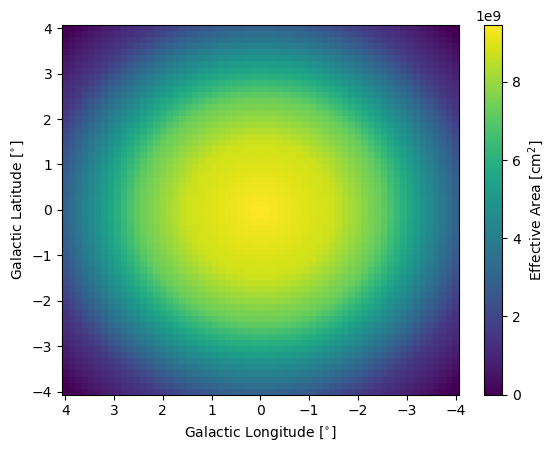

In [13]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.pcolormesh(bin_geometry.lon_axis.value, bin_geometry.lat_axis.value, np.exp(log_aeff_function_mesh_values).T)
plt.colorbar(label=r"Effective Area ["+(irf_loglike_instance.aeff_units).to_string('latex')+r"]")
plt.xlabel(r"Galactic Longitude ["+bin_geometry.lon_axis.unit.to_string('latex')+"]")
plt.ylabel(r"Galactic Latitude ["+bin_geometry.lat_axis.unit.to_string('latex')+"]")
ax = fig.get_axes()[0]
ax.invert_xaxis()

So a simple exposure would be the product of this with the observation time.

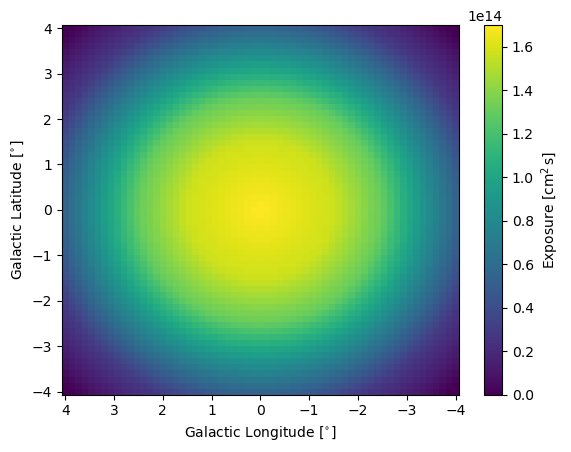

In [14]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.pcolormesh(bin_geometry.lon_axis.value, bin_geometry.lat_axis.value, np.exp(log_aeff_function_mesh_values).T*observation_time.to("s").value, norm='linear')
plt.colorbar(label=r"Exposure ["+(irf_loglike_instance.aeff_units*observation_time.to("s").unit).to_string('latex')+r"]")
plt.xlabel(r"Galactic Longitude ["+bin_geometry.lon_axis.unit.to_string('latex')+"]")
plt.ylabel(r"Galactic Latitude ["+bin_geometry.lat_axis.unit.to_string('latex')+"]")
ax = fig.get_axes()[0]
ax.invert_xaxis()

This quantity is pretty fundamental to `GammaBayes` both in terms of computation speed and purely not wanting to mess it up because issues with the values here would propagate through every stage of the calculations involving `GammaBayes`. So we have a dedicated class for this called `GammaLogExposure`.

In [15]:
from gammabayes import GammaLogExposure

log_exposure = GammaLogExposure(binning_geometry=bin_geometry, irfs=irf_loglike_instance, 
                                pointing_dir=pointing_dir, observation_time=observation_time,
                                observation_time_unit=u.s)

- The `irfs` input is required so that the `GammaLogExposure` instance can have access to a standardized function for the effective area.
- `observation_time_unit` is where you can specify a time that you would like your exposures to be converted in regardless of input observation time unit. This is handy as observation runs are typically measured in hours while astrophysical flux models are typically in units of seconds (seconds is the default for `observation_time_unit`)

We can "peek" at the exposure using the `peek` method

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


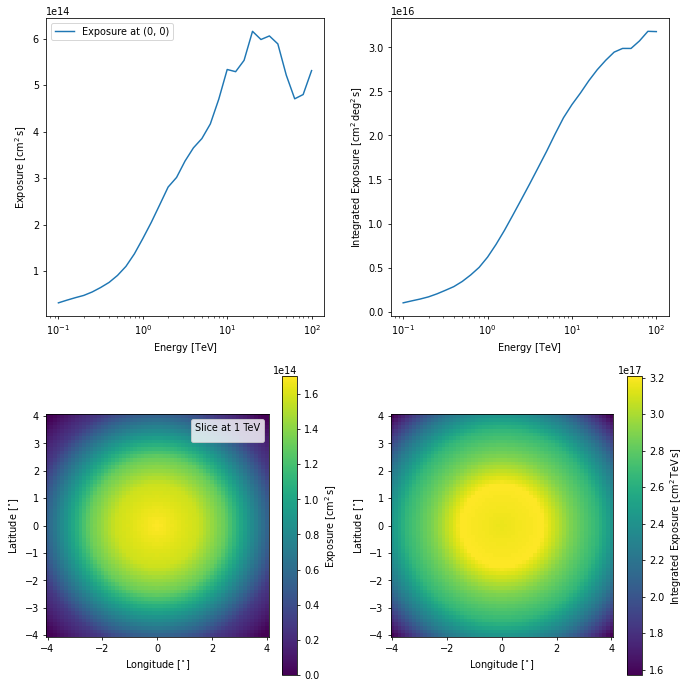

In [16]:
log_exposure.peek(figsize=(10,10), pcolormesh_kwargs={'norm':'linear'}, dpi=70)
plt.show()

# Multiple exposures

Now let's say you have 4 observations alternating between 5 and 0.5 hours centred around the galactic centre as shown below.

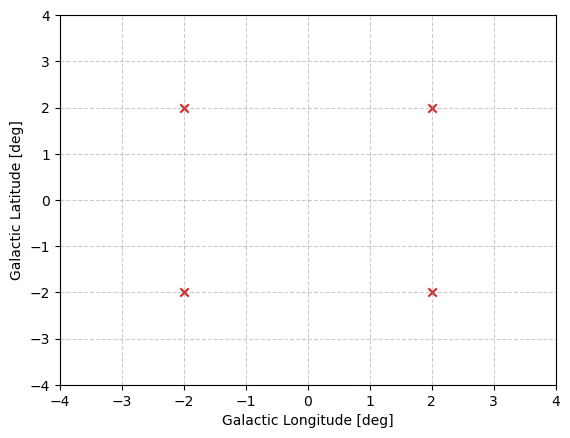

In [17]:
pointing_dirs = [
    np.array([-2, 2])*u.deg,
    np.array([2, 2])*u.deg,
    np.array([0., 0.])*u.deg,

    np.array([-2, -2])*u.deg,
    np.array([2, -2])*u.deg,
    ]
observation_times = [5*u.hr, 0.5*u.hr, 0.5*u.hr, 5*u.hr,]

plt.figure()
for coord in pointing_dirs:
    plt.scatter(x=coord[0], y=coord[1], marker='x', c='tab:red')
plt.xlim([bin_geometry.lon_axis.value.min(), bin_geometry.lon_axis.value.max()])
plt.ylim([bin_geometry.lat_axis.value.min(), bin_geometry.lat_axis.value.max()])
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
plt.grid(which='both', c='grey', ls='--', alpha=0.4)
plt.show()

Each observation run would have it's own exposure, which we can construct with the following.

In [8]:
log_exposures = [GammaLogExposure(binning_geometry=bin_geometry, 
                                 irfs=irf_loglike_instance,
                                 pointing_dir=pointing,
                                 observation_time=obs_time,
                                 ) for pointing, obs_time in zip(pointing_dirs, observation_times)]

Quite commonly we will then want to combine these exposures into a single combined exposure, this can be done a couple ways. 

Firstly, the manual way by accessing the log exposure values directly. We do not recommend this as you can have several issues with the handling of units and the like but it would go something like this.

In [9]:
from scipy.special import logsumexp

combined_log_exposure = logsumexp([log_exposure.log_exposure_map for log_exposure in log_exposures], axis=0)

And then I'm going to put this back into a GammaLogExposure class essentially for the plotting.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


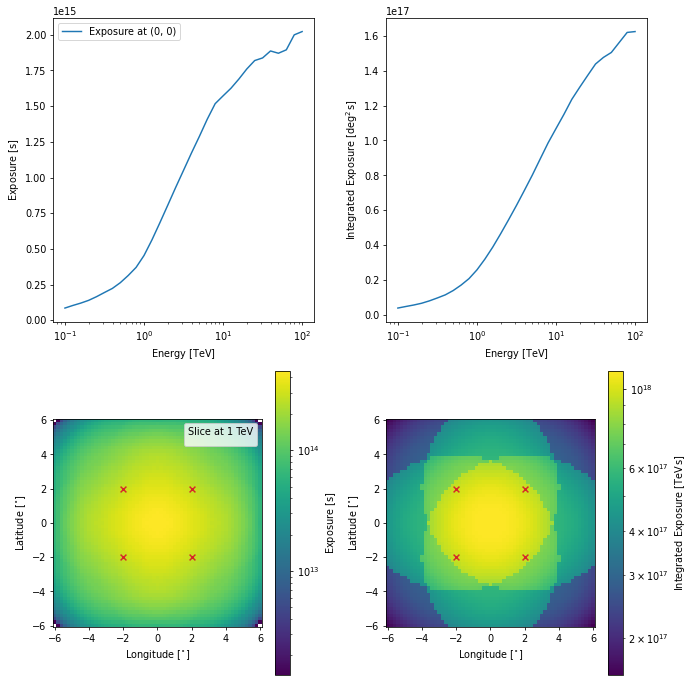

In [10]:
combined_log_exposure_class_instance = GammaLogExposure(binning_geometry=bin_geometry, 
                                                        log_exposure_map=combined_log_exposure)

fig, ax = combined_log_exposure_class_instance.peek(pcolormesh_kwargs={"norm":"log"})
for coord in pointing_dirs:
    ax[1, 0].scatter(x=coord[0], y=coord[1], marker='x', c='tab:red')
    ax[1,1].scatter(x=coord[0], y=coord[1], marker='x', c='tab:red')